In [7]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import confusion_matrix

from utils import * 
from model import * 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Ground Truth Dataset 
data = np.load('./CompressedDatasets/cifar/dataset.npz')
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


U shape:  (50000, 1000)
U shape: torch.Size([50000, 1000]), sigma shape: torch.Size([3072]), V shape: torch.Size([3072, 3072])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


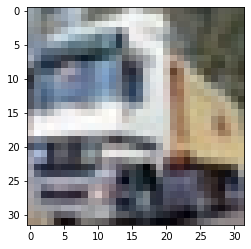

In [10]:
# Sanity check for reconstructing images
k = 1000
U, sigma, V = prepare_dataset(k)
print(f"U shape: {U.shape}, sigma shape: {sigma.shape}, V shape: {V.shape}")

reconstructed_img = reconstruct_img(U[1], sigma[:k], V[:k, :])

reconstructed_img = reconstructed_img.flatten()
U_test = (reconstructed_img @ torch.inverse(V)) @ torch.inverse(torch.diag(sigma))
new_img = U_test @ torch.diag(sigma) @ V
new_img = new_img.reshape(3, 32, 32)
new_img = new_img.permute(1, 2, 0)
plt.imshow(new_img)

In [11]:
def validate(model, test_loader): 
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_test_tensor, y_test_tensor in test_loader:
            X_test_tensor = X_test_tensor.to(device)
            y_test_tensor = y_test_tensor.to(device)

            y_test_tensor = y_test_tensor.flatten()
            outputs = model(X_test_tensor)
            _, predicted = outputs.max(1)
            correct += (predicted == y_test_tensor).sum().item()  # Accumulate correct predictions
            total += y_test_tensor.size(0)  # Accumulate total samples


    accuracy = 100. * correct / total  # Calculate overall accuracy
    # print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [14]:
def train(model, train_loader, test_loader, optimizer, epochs, criterion, experiment_name = None): 
    train_accuracy = [] 
    val_accuracy = []

    # Training loop
    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0 

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device) 
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        val_acc = validate(model, test_loader)
        val_accuracy.append(val_acc)

        train_accuracy.append(correct / total)
        # print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {correct / total:.2f}%")

        print(f"{experiment_name}: Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}, Validation Accuracy: {val_acc}%")

    # Save the model
    if experiment_name is not None:
        torch.save(model.state_dict(), f"./results/cifar-model/{experiment_name}.pth")
        print(f"Model saved as {experiment_name}.pth")
    else: 
        torch.save(model.state_dict(), f"./results/cifar-model/{experiment_name}.pth")
        print(f"Model saved as {experiment_name}.pth")

    return max(val_accuracy)

In [16]:
data = np.load('./CompressedDatasets/cifar/dataset.npz')
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)

singular_values = [] 
accuracies = [] 

for k in range(200, 3072, 200):  
    U, sigma, V = prepare_dataset(k)
    U = torch.tensor(U, dtype=torch.float32, device=device)
    sigma = torch.tensor(sigma, dtype=torch.float32, device=device)
    V = torch.tensor(V, dtype=torch.float32, device=device)
    
    # Define training parameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN(sigma, V).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    batch_size = 64
    epochs = 10

    # Create DataLoader
    train_dataset = TensorDataset(torch.tensor(U, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Train the model
    experiment_name = f"model_{k}"
    acc = train(model, train_loader, test_loader, optimizer, epochs, criterion, experiment_name)
    
    accuracies.append(acc)
    singular_values.append(k)

<ipython-input-16-c5b06b04ba4b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  U = torch.tensor(U, dtype=torch.float32, device=device)
<ipython-input-16-c5b06b04ba4b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = torch.tensor(sigma, dtype=torch.float32, device=device)
<ipython-input-16-c5b06b04ba4b>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  V = torch.tensor(V, dtype=torch.float32, device=device)
<ipython-input-16-c5b06b04ba4b>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

U shape:  (50000, 200)


 10%|█         | 1/10 [00:02<00:21,  2.37s/it]

model_200: Epoch 1/10, Loss: 1.5496, Validation Accuracy: 53.79%


 20%|██        | 2/10 [00:04<00:15,  2.00s/it]

model_200: Epoch 2/10, Loss: 1.2421, Validation Accuracy: 58.89%


 30%|███       | 3/10 [00:05<00:13,  1.89s/it]

model_200: Epoch 3/10, Loss: 1.1049, Validation Accuracy: 63.11%


 40%|████      | 4/10 [00:07<00:11,  1.85s/it]

model_200: Epoch 4/10, Loss: 1.0106, Validation Accuracy: 64.72%


 50%|█████     | 5/10 [00:09<00:08,  1.77s/it]

model_200: Epoch 5/10, Loss: 0.9408, Validation Accuracy: 64.34%


 60%|██████    | 6/10 [00:10<00:06,  1.71s/it]

model_200: Epoch 6/10, Loss: 0.8835, Validation Accuracy: 65.73%


 70%|███████   | 7/10 [00:12<00:05,  1.68s/it]

model_200: Epoch 7/10, Loss: 0.8306, Validation Accuracy: 66.59%


 80%|████████  | 8/10 [00:14<00:03,  1.66s/it]

model_200: Epoch 8/10, Loss: 0.7765, Validation Accuracy: 66.58%


 90%|█████████ | 9/10 [00:15<00:01,  1.65s/it]

model_200: Epoch 9/10, Loss: 0.7263, Validation Accuracy: 67.41%


100%|██████████| 10/10 [00:17<00:00,  1.74s/it]

model_200: Epoch 10/10, Loss: 0.6770, Validation Accuracy: 66.35%
Model saved as model_200.pth


U shape:  (50000, 400)


 10%|█         | 1/10 [00:01<00:14,  1.60s/it]

model_400: Epoch 1/10, Loss: 1.5493, Validation Accuracy: 54.97%


 20%|██        | 2/10 [00:03<00:12,  1.62s/it]

model_400: Epoch 2/10, Loss: 1.1919, Validation Accuracy: 59.03%


 30%|███       | 3/10 [00:04<00:11,  1.62s/it]

model_400: Epoch 3/10, Loss: 1.0509, Validation Accuracy: 64.47%


 40%|████      | 4/10 [00:06<00:09,  1.63s/it]

model_400: Epoch 4/10, Loss: 0.9454, Validation Accuracy: 65.0%


 50%|█████     | 5/10 [00:08<00:08,  1.64s/it]

model_400: Epoch 5/10, Loss: 0.8672, Validation Accuracy: 65.84%


 60%|██████    | 6/10 [00:09<00:06,  1.63s/it]

model_400: Epoch 6/10, Loss: 0.7968, Validation Accuracy: 67.8%


 70%|███████   | 7/10 [00:11<00:04,  1.62s/it]

model_400: Epoch 7/10, Loss: 0.7348, Validation Accuracy: 67.92%


 80%|████████  | 8/10 [00:13<00:03,  1.64s/it]

model_400: Epoch 8/10, Loss: 0.6790, Validation Accuracy: 68.57%


 90%|█████████ | 9/10 [00:14<00:01,  1.64s/it]

model_400: Epoch 9/10, Loss: 0.6256, Validation Accuracy: 68.77%


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

model_400: Epoch 10/10, Loss: 0.5713, Validation Accuracy: 67.44%
Model saved as model_400.pth


U shape:  (50000, 600)


 10%|█         | 1/10 [00:01<00:14,  1.66s/it]

model_600: Epoch 1/10, Loss: 1.4775, Validation Accuracy: 56.04%


 20%|██        | 2/10 [00:03<00:13,  1.65s/it]

model_600: Epoch 2/10, Loss: 1.1130, Validation Accuracy: 63.44%


 30%|███       | 3/10 [00:05<00:11,  1.70s/it]

model_600: Epoch 3/10, Loss: 0.9712, Validation Accuracy: 66.21%


 40%|████      | 4/10 [00:06<00:10,  1.72s/it]

model_600: Epoch 4/10, Loss: 0.8832, Validation Accuracy: 65.82%


 50%|█████     | 5/10 [00:08<00:08,  1.71s/it]

model_600: Epoch 5/10, Loss: 0.8156, Validation Accuracy: 69.22%


 60%|██████    | 6/10 [00:10<00:06,  1.74s/it]

model_600: Epoch 6/10, Loss: 0.7536, Validation Accuracy: 69.79%


 70%|███████   | 7/10 [00:12<00:05,  1.74s/it]

model_600: Epoch 7/10, Loss: 0.6973, Validation Accuracy: 69.71%


 80%|████████  | 8/10 [00:13<00:03,  1.71s/it]

model_600: Epoch 8/10, Loss: 0.6483, Validation Accuracy: 70.55%


 90%|█████████ | 9/10 [00:15<00:01,  1.74s/it]

model_600: Epoch 9/10, Loss: 0.5924, Validation Accuracy: 70.63%


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

model_600: Epoch 10/10, Loss: 0.5434, Validation Accuracy: 69.11%
Model saved as model_600.pth


U shape:  (50000, 800)


 10%|█         | 1/10 [00:01<00:16,  1.78s/it]

model_800: Epoch 1/10, Loss: 1.4667, Validation Accuracy: 56.5%


 20%|██        | 2/10 [00:03<00:14,  1.79s/it]

model_800: Epoch 2/10, Loss: 1.1187, Validation Accuracy: 63.32%


 30%|███       | 3/10 [00:05<00:12,  1.79s/it]

model_800: Epoch 3/10, Loss: 0.9543, Validation Accuracy: 65.36%


 40%|████      | 4/10 [00:07<00:10,  1.78s/it]

model_800: Epoch 4/10, Loss: 0.8564, Validation Accuracy: 68.16%


 50%|█████     | 5/10 [00:08<00:08,  1.78s/it]

model_800: Epoch 5/10, Loss: 0.7693, Validation Accuracy: 68.58%


 60%|██████    | 6/10 [00:10<00:07,  1.77s/it]

model_800: Epoch 6/10, Loss: 0.6992, Validation Accuracy: 70.12%


 70%|███████   | 7/10 [00:12<00:05,  1.77s/it]

model_800: Epoch 7/10, Loss: 0.6285, Validation Accuracy: 70.75%


 80%|████████  | 8/10 [00:14<00:03,  1.77s/it]

model_800: Epoch 8/10, Loss: 0.5699, Validation Accuracy: 70.75%


 90%|█████████ | 9/10 [00:15<00:01,  1.76s/it]

model_800: Epoch 9/10, Loss: 0.5103, Validation Accuracy: 70.37%


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]

model_800: Epoch 10/10, Loss: 0.4490, Validation Accuracy: 70.52%
Model saved as model_800.pth



  0%|          | 0/10 [00:00<?, ?it/s]

U shape:  (50000, 1000)


 10%|█         | 1/10 [00:01<00:15,  1.67s/it]

model_1000: Epoch 1/10, Loss: 1.4881, Validation Accuracy: 56.11%


 20%|██        | 2/10 [00:03<00:13,  1.73s/it]

model_1000: Epoch 2/10, Loss: 1.1660, Validation Accuracy: 58.73%


 30%|███       | 3/10 [00:05<00:12,  1.72s/it]

model_1000: Epoch 3/10, Loss: 1.0080, Validation Accuracy: 64.57%


 40%|████      | 4/10 [00:06<00:10,  1.72s/it]

model_1000: Epoch 4/10, Loss: 0.9076, Validation Accuracy: 66.42%


 50%|█████     | 5/10 [00:08<00:08,  1.75s/it]

model_1000: Epoch 5/10, Loss: 0.8361, Validation Accuracy: 67.28%


 60%|██████    | 6/10 [00:10<00:06,  1.74s/it]

model_1000: Epoch 6/10, Loss: 0.7711, Validation Accuracy: 68.77%


 70%|███████   | 7/10 [00:12<00:05,  1.73s/it]

model_1000: Epoch 7/10, Loss: 0.7103, Validation Accuracy: 69.73%


 80%|████████  | 8/10 [00:13<00:03,  1.71s/it]

model_1000: Epoch 8/10, Loss: 0.6541, Validation Accuracy: 69.78%


 90%|█████████ | 9/10 [00:15<00:01,  1.72s/it]

model_1000: Epoch 9/10, Loss: 0.5994, Validation Accuracy: 69.99%


100%|██████████| 10/10 [00:17<00:00,  1.72s/it]

model_1000: Epoch 10/10, Loss: 0.5492, Validation Accuracy: 68.76%
Model saved as model_1000.pth


U shape:  (50000, 1200)


 10%|█         | 1/10 [00:01<00:15,  1.67s/it]

model_1200: Epoch 1/10, Loss: 1.5089, Validation Accuracy: 55.96%


 20%|██        | 2/10 [00:03<00:13,  1.72s/it]

model_1200: Epoch 2/10, Loss: 1.1708, Validation Accuracy: 60.98%


 30%|███       | 3/10 [00:05<00:11,  1.69s/it]

model_1200: Epoch 3/10, Loss: 1.0080, Validation Accuracy: 64.96%


 40%|████      | 4/10 [00:06<00:10,  1.68s/it]

model_1200: Epoch 4/10, Loss: 0.9018, Validation Accuracy: 67.55%


 50%|█████     | 5/10 [00:08<00:08,  1.69s/it]

model_1200: Epoch 5/10, Loss: 0.8202, Validation Accuracy: 66.18%


 60%|██████    | 6/10 [00:10<00:06,  1.68s/it]

model_1200: Epoch 6/10, Loss: 0.7505, Validation Accuracy: 69.09%


 70%|███████   | 7/10 [00:11<00:05,  1.69s/it]

model_1200: Epoch 7/10, Loss: 0.6898, Validation Accuracy: 69.62%


 80%|████████  | 8/10 [00:13<00:03,  1.67s/it]

model_1200: Epoch 8/10, Loss: 0.6268, Validation Accuracy: 69.49%


 90%|█████████ | 9/10 [00:15<00:01,  1.68s/it]

model_1200: Epoch 9/10, Loss: 0.5673, Validation Accuracy: 70.13%


100%|██████████| 10/10 [00:16<00:00,  1.69s/it]

model_1200: Epoch 10/10, Loss: 0.5131, Validation Accuracy: 69.97%
Model saved as model_1200.pth


U shape:  (50000, 1400)


 10%|█         | 1/10 [00:01<00:16,  1.81s/it]

model_1400: Epoch 1/10, Loss: 1.5014, Validation Accuracy: 54.49%


 20%|██        | 2/10 [00:03<00:14,  1.81s/it]

model_1400: Epoch 2/10, Loss: 1.1360, Validation Accuracy: 62.44%


 30%|███       | 3/10 [00:05<00:12,  1.82s/it]

model_1400: Epoch 3/10, Loss: 0.9843, Validation Accuracy: 66.78%


 40%|████      | 4/10 [00:07<00:10,  1.82s/it]

model_1400: Epoch 4/10, Loss: 0.8947, Validation Accuracy: 67.28%


 50%|█████     | 5/10 [00:09<00:09,  1.82s/it]

model_1400: Epoch 5/10, Loss: 0.8162, Validation Accuracy: 67.13%


 60%|██████    | 6/10 [00:10<00:07,  1.82s/it]

model_1400: Epoch 6/10, Loss: 0.7514, Validation Accuracy: 69.9%


 70%|███████   | 7/10 [00:12<00:05,  1.82s/it]

model_1400: Epoch 7/10, Loss: 0.6961, Validation Accuracy: 70.35%


 80%|████████  | 8/10 [00:14<00:03,  1.82s/it]

model_1400: Epoch 8/10, Loss: 0.6408, Validation Accuracy: 70.97%


 90%|█████████ | 9/10 [00:16<00:01,  1.82s/it]

model_1400: Epoch 9/10, Loss: 0.5903, Validation Accuracy: 70.53%


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]

model_1400: Epoch 10/10, Loss: 0.5442, Validation Accuracy: 71.1%
Model saved as model_1400.pth


U shape:  (50000, 1600)


 10%|█         | 1/10 [00:01<00:16,  1.83s/it]

model_1600: Epoch 1/10, Loss: 1.4959, Validation Accuracy: 56.47%


 20%|██        | 2/10 [00:03<00:14,  1.83s/it]

model_1600: Epoch 2/10, Loss: 1.1375, Validation Accuracy: 62.97%


 30%|███       | 3/10 [00:05<00:12,  1.83s/it]

model_1600: Epoch 3/10, Loss: 0.9765, Validation Accuracy: 66.84%


 40%|████      | 4/10 [00:07<00:10,  1.83s/it]

model_1600: Epoch 4/10, Loss: 0.8769, Validation Accuracy: 67.19%


 50%|█████     | 5/10 [00:09<00:09,  1.81s/it]

model_1600: Epoch 5/10, Loss: 0.8029, Validation Accuracy: 69.28%


 60%|██████    | 6/10 [00:10<00:07,  1.82s/it]

model_1600: Epoch 6/10, Loss: 0.7347, Validation Accuracy: 69.03%


 70%|███████   | 7/10 [00:12<00:05,  1.82s/it]

model_1600: Epoch 7/10, Loss: 0.6717, Validation Accuracy: 70.32%


 80%|████████  | 8/10 [00:14<00:03,  1.83s/it]

model_1600: Epoch 8/10, Loss: 0.6159, Validation Accuracy: 69.66%


 90%|█████████ | 9/10 [00:16<00:01,  1.82s/it]

model_1600: Epoch 9/10, Loss: 0.5593, Validation Accuracy: 71.12%


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]

model_1600: Epoch 10/10, Loss: 0.5080, Validation Accuracy: 69.95%
Model saved as model_1600.pth


U shape:  (50000, 1800)


 10%|█         | 1/10 [00:01<00:17,  1.99s/it]

model_1800: Epoch 1/10, Loss: 1.4793, Validation Accuracy: 54.73%


 20%|██        | 2/10 [00:03<00:15,  1.98s/it]

model_1800: Epoch 2/10, Loss: 1.1275, Validation Accuracy: 62.68%


 30%|███       | 3/10 [00:05<00:13,  1.97s/it]

model_1800: Epoch 3/10, Loss: 0.9692, Validation Accuracy: 65.63%


 40%|████      | 4/10 [00:07<00:11,  1.97s/it]

model_1800: Epoch 4/10, Loss: 0.8618, Validation Accuracy: 66.44%


 50%|█████     | 5/10 [00:09<00:09,  1.97s/it]

model_1800: Epoch 5/10, Loss: 0.7783, Validation Accuracy: 67.6%


 60%|██████    | 6/10 [00:11<00:07,  1.97s/it]

model_1800: Epoch 6/10, Loss: 0.7072, Validation Accuracy: 71.47%


 70%|███████   | 7/10 [00:13<00:05,  1.96s/it]

model_1800: Epoch 7/10, Loss: 0.6410, Validation Accuracy: 71.1%


 80%|████████  | 8/10 [00:15<00:03,  1.97s/it]

model_1800: Epoch 8/10, Loss: 0.5800, Validation Accuracy: 71.4%


 90%|█████████ | 9/10 [00:18<00:02,  2.34s/it]

model_1800: Epoch 9/10, Loss: 0.5227, Validation Accuracy: 70.43%


100%|██████████| 10/10 [00:22<00:00,  2.24s/it]

model_1800: Epoch 10/10, Loss: 0.4673, Validation Accuracy: 70.88%
Model saved as model_1800.pth


U shape:  (50000, 2000)


 10%|█         | 1/10 [00:02<00:18,  2.07s/it]

model_2000: Epoch 1/10, Loss: 1.4961, Validation Accuracy: 55.81%


 20%|██        | 2/10 [00:04<00:16,  2.07s/it]

model_2000: Epoch 2/10, Loss: 1.1361, Validation Accuracy: 62.54%


 30%|███       | 3/10 [00:06<00:14,  2.08s/it]

model_2000: Epoch 3/10, Loss: 0.9717, Validation Accuracy: 66.03%


 40%|████      | 4/10 [00:08<00:12,  2.09s/it]

model_2000: Epoch 4/10, Loss: 0.8675, Validation Accuracy: 68.3%


 50%|█████     | 5/10 [00:10<00:10,  2.08s/it]

model_2000: Epoch 5/10, Loss: 0.7925, Validation Accuracy: 68.8%


 60%|██████    | 6/10 [00:12<00:08,  2.08s/it]

model_2000: Epoch 6/10, Loss: 0.7225, Validation Accuracy: 70.16%


 70%|███████   | 7/10 [00:14<00:06,  2.07s/it]

model_2000: Epoch 7/10, Loss: 0.6558, Validation Accuracy: 70.46%


 80%|████████  | 8/10 [00:16<00:04,  2.07s/it]

model_2000: Epoch 8/10, Loss: 0.5976, Validation Accuracy: 71.1%


 90%|█████████ | 9/10 [00:18<00:02,  2.07s/it]

model_2000: Epoch 9/10, Loss: 0.5392, Validation Accuracy: 70.32%


100%|██████████| 10/10 [00:20<00:00,  2.08s/it]

model_2000: Epoch 10/10, Loss: 0.4933, Validation Accuracy: 70.52%
Model saved as model_2000.pth


U shape:  (50000, 2200)


 10%|█         | 1/10 [00:02<00:20,  2.25s/it]

model_2200: Epoch 1/10, Loss: 1.5132, Validation Accuracy: 55.71%


 20%|██        | 2/10 [00:04<00:18,  2.26s/it]

model_2200: Epoch 2/10, Loss: 1.1573, Validation Accuracy: 61.1%


 30%|███       | 3/10 [00:06<00:15,  2.26s/it]

model_2200: Epoch 3/10, Loss: 1.0051, Validation Accuracy: 64.13%


 40%|████      | 4/10 [00:09<00:13,  2.27s/it]

model_2200: Epoch 4/10, Loss: 0.9057, Validation Accuracy: 66.76%


 50%|█████     | 5/10 [00:11<00:11,  2.27s/it]

model_2200: Epoch 5/10, Loss: 0.8297, Validation Accuracy: 66.05%


 60%|██████    | 6/10 [00:13<00:09,  2.27s/it]

model_2200: Epoch 6/10, Loss: 0.7684, Validation Accuracy: 68.6%


 70%|███████   | 7/10 [00:15<00:06,  2.27s/it]

model_2200: Epoch 7/10, Loss: 0.7128, Validation Accuracy: 69.19%


 80%|████████  | 8/10 [00:18<00:04,  2.30s/it]

model_2200: Epoch 8/10, Loss: 0.6621, Validation Accuracy: 70.36%


 90%|█████████ | 9/10 [00:20<00:02,  2.31s/it]

model_2200: Epoch 9/10, Loss: 0.6090, Validation Accuracy: 69.61%


100%|██████████| 10/10 [00:22<00:00,  2.28s/it]

model_2200: Epoch 10/10, Loss: 0.5657, Validation Accuracy: 69.88%
Model saved as model_2200.pth


U shape:  (50000, 2400)


 10%|█         | 1/10 [00:02<00:21,  2.42s/it]

model_2400: Epoch 1/10, Loss: 1.5085, Validation Accuracy: 55.13%


 20%|██        | 2/10 [00:04<00:19,  2.44s/it]

model_2400: Epoch 2/10, Loss: 1.1538, Validation Accuracy: 62.8%


 30%|███       | 3/10 [00:07<00:17,  2.43s/it]

model_2400: Epoch 3/10, Loss: 0.9917, Validation Accuracy: 64.67%


 40%|████      | 4/10 [00:09<00:14,  2.44s/it]

model_2400: Epoch 4/10, Loss: 0.8913, Validation Accuracy: 67.9%


 50%|█████     | 5/10 [00:12<00:12,  2.45s/it]

model_2400: Epoch 5/10, Loss: 0.8145, Validation Accuracy: 68.72%


 60%|██████    | 6/10 [00:14<00:09,  2.45s/it]

model_2400: Epoch 6/10, Loss: 0.7476, Validation Accuracy: 69.76%


 70%|███████   | 7/10 [00:17<00:07,  2.43s/it]

model_2400: Epoch 7/10, Loss: 0.6920, Validation Accuracy: 69.95%


 80%|████████  | 8/10 [00:19<00:04,  2.43s/it]

model_2400: Epoch 8/10, Loss: 0.6366, Validation Accuracy: 69.38%


 90%|█████████ | 9/10 [00:21<00:02,  2.42s/it]

model_2400: Epoch 9/10, Loss: 0.5900, Validation Accuracy: 70.36%


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]

model_2400: Epoch 10/10, Loss: 0.5418, Validation Accuracy: 69.66%
Model saved as model_2400.pth


U shape:  (50000, 2600)


 10%|█         | 1/10 [00:02<00:22,  2.47s/it]

model_2600: Epoch 1/10, Loss: 1.4635, Validation Accuracy: 52.75%


 20%|██        | 2/10 [00:04<00:19,  2.48s/it]

model_2600: Epoch 2/10, Loss: 1.0979, Validation Accuracy: 64.42%


 30%|███       | 3/10 [00:07<00:17,  2.50s/it]

model_2600: Epoch 3/10, Loss: 0.9452, Validation Accuracy: 66.75%


 40%|████      | 4/10 [00:09<00:15,  2.50s/it]

model_2600: Epoch 4/10, Loss: 0.8447, Validation Accuracy: 67.55%


 50%|█████     | 5/10 [00:12<00:12,  2.53s/it]

model_2600: Epoch 5/10, Loss: 0.7519, Validation Accuracy: 68.35%


 60%|██████    | 6/10 [00:15<00:10,  2.52s/it]

model_2600: Epoch 6/10, Loss: 0.6798, Validation Accuracy: 70.1%


 70%|███████   | 7/10 [00:17<00:07,  2.52s/it]

model_2600: Epoch 7/10, Loss: 0.6152, Validation Accuracy: 70.1%


 80%|████████  | 8/10 [00:20<00:05,  2.51s/it]

model_2600: Epoch 8/10, Loss: 0.5488, Validation Accuracy: 69.87%


 90%|█████████ | 9/10 [00:22<00:02,  2.52s/it]

model_2600: Epoch 9/10, Loss: 0.4859, Validation Accuracy: 69.94%


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]

model_2600: Epoch 10/10, Loss: 0.4256, Validation Accuracy: 70.82%
Model saved as model_2600.pth


U shape:  (50000, 2800)


 10%|█         | 1/10 [00:02<00:25,  2.86s/it]

model_2800: Epoch 1/10, Loss: 1.4891, Validation Accuracy: 55.5%


 20%|██        | 2/10 [00:05<00:22,  2.86s/it]

model_2800: Epoch 2/10, Loss: 1.1375, Validation Accuracy: 62.24%


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

model_2800: Epoch 3/10, Loss: 0.9816, Validation Accuracy: 64.45%


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

model_2800: Epoch 4/10, Loss: 0.8856, Validation Accuracy: 67.17%


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

model_2800: Epoch 5/10, Loss: 0.8028, Validation Accuracy: 68.48%


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

model_2800: Epoch 6/10, Loss: 0.7460, Validation Accuracy: 69.28%


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

model_2800: Epoch 7/10, Loss: 0.6839, Validation Accuracy: 69.91%


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

model_2800: Epoch 8/10, Loss: 0.6268, Validation Accuracy: 70.29%


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

model_2800: Epoch 9/10, Loss: 0.5736, Validation Accuracy: 70.88%


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

model_2800: Epoch 10/10, Loss: 0.5150, Validation Accuracy: 70.14%
Model saved as model_2800.pth


U shape:  (50000, 3000)


 10%|█         | 1/10 [00:03<00:27,  3.01s/it]

model_3000: Epoch 1/10, Loss: 1.4687, Validation Accuracy: 55.84%


 20%|██        | 2/10 [00:06<00:24,  3.03s/it]

model_3000: Epoch 2/10, Loss: 1.1164, Validation Accuracy: 62.7%


 30%|███       | 3/10 [00:09<00:21,  3.03s/it]

model_3000: Epoch 3/10, Loss: 0.9498, Validation Accuracy: 66.24%


 40%|████      | 4/10 [00:12<00:18,  3.03s/it]

model_3000: Epoch 4/10, Loss: 0.8481, Validation Accuracy: 68.36%


 50%|█████     | 5/10 [00:15<00:15,  3.03s/it]

model_3000: Epoch 5/10, Loss: 0.7651, Validation Accuracy: 69.71%


 60%|██████    | 6/10 [00:18<00:12,  3.04s/it]

model_3000: Epoch 6/10, Loss: 0.6966, Validation Accuracy: 70.16%


 70%|███████   | 7/10 [00:21<00:09,  3.03s/it]

model_3000: Epoch 7/10, Loss: 0.6246, Validation Accuracy: 70.34%


 80%|████████  | 8/10 [00:24<00:06,  3.03s/it]

model_3000: Epoch 8/10, Loss: 0.5659, Validation Accuracy: 71.07%


 90%|█████████ | 9/10 [00:27<00:03,  3.02s/it]

model_3000: Epoch 9/10, Loss: 0.5038, Validation Accuracy: 71.09%


100%|██████████| 10/10 [00:30<00:00,  3.03s/it]

model_3000: Epoch 10/10, Loss: 0.4452, Validation Accuracy: 71.19%
Model saved as model_3000.pth


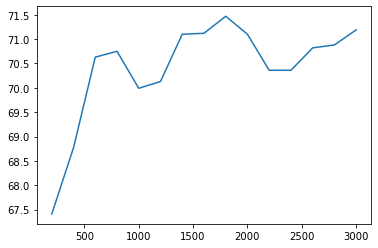

In [17]:
plt.plot(singular_values, accuracies)